## This is exact same version of Final Image Classificaiton notebook.

Except this does not use weighted classes

In [1]:
import os, sys, re, string, pathlib, random, io, time, glob
from collections import Counter, OrderedDict
from shutil import copyfile, rmtree

#import hecutils.resnet152 as resnet
from hecutils.resnet152 import ResNet152

import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords

import hecutils.data_utils as dt
import hecutils.scoring_utils as sc
import hecutils.plotting_utils as pt
import hecutils.image_utils as imut



import tensorflow as tf
from keras import backend as K
from keras import regularizers
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, Callback
from keras.layers import GRU, Bidirectional, LSTM, MaxPooling1D, Conv1D,Dense, GlobalAveragePooling2D, GlobalMaxPooling2D
from keras.layers.core import Dropout, Flatten, Masking, ActivityRegularization
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential
from keras.utils import plot_model
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.preprocessing import text
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.models import Model
from keras import optimizers

# from fastText import load_model
from gensim.models import word2vec
from gensim.models.keyedvectors import KeyedVectors


import numpy as np
import pandas as pd
from sklearn.utils import shuffle, class_weight
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import confusion_matrix

from os import listdir
from os.path import isfile, join


%matplotlib inline 

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


None


In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import tensorflow as tf
from keras import backend as K

num_cores = 8
GPU=True
CPU = not GPU

if GPU:
    num_GPU = 1
    num_CPU = 8
if CPU:
    num_CPU = 8
    num_GPU = 0

config = tf.ConfigProto(intra_op_parallelism_threads=num_cores,\
        inter_op_parallelism_threads=num_cores, allow_soft_placement=True,\
        device_count = {'CPU' : num_CPU, 'GPU' : num_GPU})
session = tf.Session(config=config)
K.set_session(session)

In [3]:
oasis_csv_path = "dataset/metadata/OASIS.csv"
oasis_images_src = "dataset/images/"
input_images_src = "dataset/input2/"
test_images_src = "dataset/test2/"
model_results_root_dir = "img_model2/"

input_images_classified = "dataset/input-classified2/"
test_images_classified = "dataset/test-classified2/"

# ou can downlaod weights here: https://gist.github.com/flyyufelix/7e2eafb149f72f4d38dd661882c554a6
weights_path = "/home/elkhand/weights/resnet152_weights_tf.h5"

dataset_groups=["train", "val"]
classes = ["negative", "neutral", "positive"]

# fix random seed for reproducibility
seed = 7

test_size = 0.1

kfold_splits = 5 #5

neutralLow = 3.0
neutralHigh = 5.0

nb_epochs = 100
patience = 10 # ReduceLROnPlateau has 5
batch_size = 32 # 32  

FC_SIZE = 1024 # 128 # 1024
LAYERS_TO_UNFREEZE = 10

img_height = 224 # 299
img_width = 224  # 299

useF1Score = False
verbose=1 



In [4]:
image_names, image_labels = dt.get_image_name_and_label(oasis_csv_path, neutralLow, neutralHigh)
imageNameToImageId = dt.get_image_title_to_image_id(oasis_csv_path)

for i in range(5):
    imageName = image_names[i]
    imageName = imageName.split(".")[0]
    print(imageNameToImageId[imageName], image_labels[i])
    
print("\n")

for i in range(-5,0,1):
    imageName = image_names[i]
    imageName = imageName.split(".")[0]
    print(imageNameToImageId[imageName], image_labels[i])    
print("\n")
    
imageNameToLabel = {}

for img_name,label in zip(image_names, image_labels):
    if img_name not in imageNameToLabel:
        imageNameToLabel[img_name] = label
    else:
        raise "There should not be images with same name: " + img_name + label    
        
image_names = np.array(image_names)
image_labels = np.array(image_labels)

input_x, test_x, input_y,  test_y = train_test_split(image_names, image_labels,
                                                    test_size=test_size,
                                                    random_state=seed,
                                                    stratify=image_labels)

print("Input data (to be used for model learning and validation) label distribution: \n",pt.get_label_count(input_y))
print()
print("Test data(never used for learning) label distribution: \n",pt.get_label_count(test_y))


# Delete input images dir
rmtree(input_images_src, ignore_errors=True)
os.makedirs(input_images_src)


# Delete test images dir
rmtree(test_images_src, ignore_errors=True)
os.makedirs(test_images_src)


# Copy input images into input dir, and test images into test dir
imut.copy_imgs_into(oasis_images_src, input_x, input_images_src)
imut.copy_imgs_into(oasis_images_src, test_x, test_images_src)



I1 neutral
I10 neutral
I100 neutral
I101 neutral
I102 neutral


I95 neutral
I96 positive
I97 neutral
I98 positive
I99 positive


Input data (to be used for model learning and validation) label distribution: 
 OrderedDict([('negative', 147), ('neutral', 378), ('positive', 285)])

Test data(never used for learning) label distribution: 
 OrderedDict([('negative', 16), ('neutral', 42), ('positive', 32)])


config:
 {'img_height': 224, 'img_width': 224, 'kfold_splits': 5, 'batch_size': 32, 'nb_epochs': 100, 'useF1Score': False, 'verbose': 1}
train_indices[:5] [0 1 2 3 4] train_indices[-5:] [804 805 806 808 809]
val_indices[:5] [ 5  8  9 24 26] val_indices[-5:] [779 791 796 799 807]

Train size:  647
Val size:  163
Train label distribution:  OrderedDict([('negative', 117), ('neutral', 302), ('positive', 228)])
Val label distribution:  OrderedDict([('negative', 30), ('neutral', 76), ('positive', 57)])

class_weights [1.84330484 0.71412804 0.94590643]
Found 647 images belonging to 3 classes.
Found 163 images belonging to 3 classes.


/home/elkhand/anaconda3/envs/cs231n/lib/python3.6/site-packages/ipykernel_launcher.py:54: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`



Epoch 1/3
62/62 [==============================] - 29s 469ms/step - loss: 2.2279 - acc: 0.4651 - val_loss: 0.9655 - val_acc: 0.6125
Epoch 2/3
62/62 [==============================] - 27s 434ms/step - loss: 1.2388 - acc: 0.5405 - val_loss: 0.9245 - val_acc: 0.6188
Epoch 3/3
62/62 [==============================] - 27s 428ms/step - loss: 1.0312 - acc: 0.5712 - val_loss: 0.8100 - val_acc: 0.6625
Starting fune-tuning
LAYERS_TO_UNFREEZE: 10 last layer id to freeze 716 total layers,  726
Epoch 1/100
62/62 [==============================] - 29s 476ms/step - loss: 0.9848 - acc: 0.6096 - val_loss: 0.8180 - val_acc: 0.6438
Epoch 2/100
62/62 [==============================] - 27s 439ms/step - loss: 0.8740 - acc: 0.6166 - val_loss: 0.8446 - val_acc: 0.6438
Epoch 3/100
62/62 [==============================] - 26s 423ms/step - loss: 0.8292 - acc: 0.6323 - val_loss: 0.8778 - val_acc: 0.5813

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0007000000332482159.
Epoch 4/100
62/62 [==========

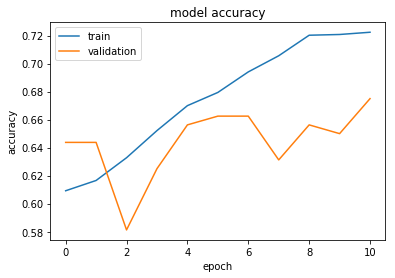

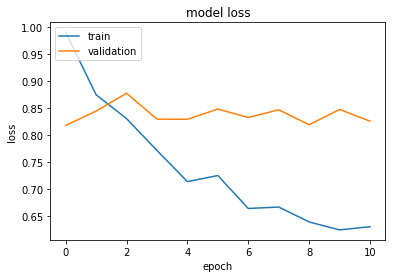

best_val_acc 0.675
train_indices[:5] [0 1 3 4 5] train_indices[-5:] [804 806 807 808 809]
val_indices[:5] [ 2 11 22 28 31] val_indices[-5:] [794 800 801 803 805]

Train size:  647
Val size:  163
Train label distribution:  OrderedDict([('negative', 117), ('neutral', 302), ('positive', 228)])
Val label distribution:  OrderedDict([('negative', 30), ('neutral', 76), ('positive', 57)])

class_weights [1.84330484 0.71412804 0.94590643]
Found 647 images belonging to 3 classes.
Found 163 images belonging to 3 classes.

Epoch 1/3
62/62 [==============================] - 32s 514ms/step - loss: 6.4247 - acc: 0.4515 - val_loss: 1.0884 - val_acc: 0.5188
Epoch 2/3
62/62 [==============================] - 26s 421ms/step - loss: 1.4634 - acc: 0.5180 - val_loss: 1.0193 - val_acc: 0.5750
Epoch 3/3
62/62 [==============================] - 26s 413ms/step - loss: 1.0995 - acc: 0.5622 - val_loss: 0.9580 - val_acc: 0.5500
Starting fune-tuning
LAYERS_TO_UNFREEZE: 10 last layer id to freeze 716 total layers,  

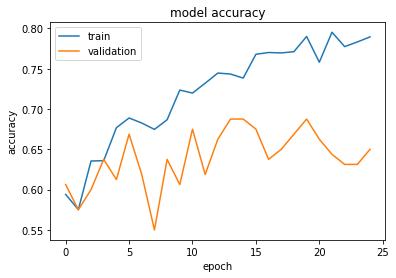

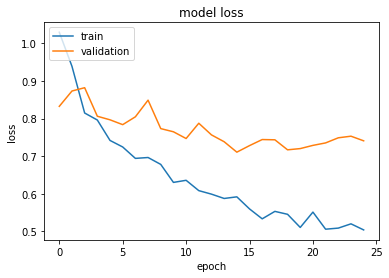

best_val_acc 0.6875
train_indices[:5] [0 1 2 3 5] train_indices[-5:] [804 805 807 808 809]
val_indices[:5] [ 4  6 10 14 17] val_indices[-5:] [788 793 795 798 806]

Train size:  648
Val size:  162
Train label distribution:  OrderedDict([('negative', 118), ('neutral', 302), ('positive', 228)])
Val label distribution:  OrderedDict([('negative', 29), ('neutral', 76), ('positive', 57)])

class_weights [1.83050847 0.71523179 0.94736842]
Found 648 images belonging to 3 classes.
Found 162 images belonging to 3 classes.

Epoch 1/3
62/62 [==============================] - 33s 528ms/step - loss: 2.3167 - acc: 0.4430 - val_loss: 1.0275 - val_acc: 0.5625
Epoch 2/3
62/62 [==============================] - 27s 439ms/step - loss: 1.1702 - acc: 0.5266 - val_loss: 0.9269 - val_acc: 0.5875
Epoch 3/3
62/62 [==============================] - 26s 419ms/step - loss: 1.0419 - acc: 0.5776 - val_loss: 0.8085 - val_acc: 0.6438
Starting fune-tuning
LAYERS_TO_UNFREEZE: 10 last layer id to freeze 716 total layers, 

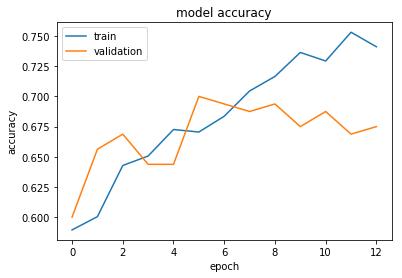

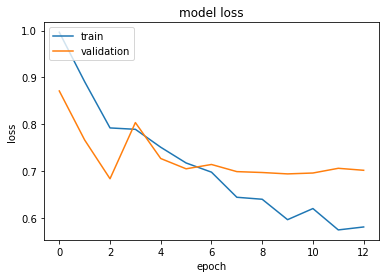

best_val_acc 0.7
train_indices[:5] [2 3 4 5 6] train_indices[-5:] [803 805 806 807 808]
val_indices[:5] [ 0  1  7 12 13] val_indices[-5:] [776 780 797 804 809]

Train size:  649
Val size:  161
Train label distribution:  OrderedDict([('negative', 118), ('neutral', 303), ('positive', 228)])
Val label distribution:  OrderedDict([('negative', 29), ('neutral', 75), ('positive', 57)])

class_weights [1.83333333 0.7139714  0.94883041]
Found 649 images belonging to 3 classes.
Found 161 images belonging to 3 classes.

Epoch 1/3
62/62 [==============================] - 36s 574ms/step - loss: 3.9954 - acc: 0.4540 - val_loss: 1.3417 - val_acc: 0.3937
Epoch 2/3
62/62 [==============================] - 27s 439ms/step - loss: 1.2585 - acc: 0.5301 - val_loss: 0.8363 - val_acc: 0.6000
Epoch 3/3
62/62 [==============================] - 26s 425ms/step - loss: 1.0738 - acc: 0.5548 - val_loss: 0.7960 - val_acc: 0.6062
Starting fune-tuning
LAYERS_TO_UNFREEZE: 10 last layer id to freeze 716 total layers,  72

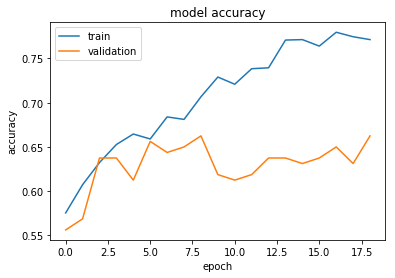

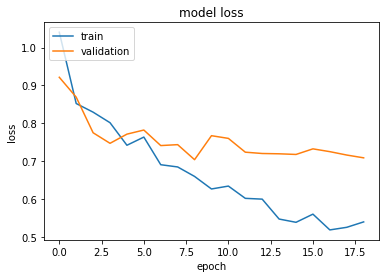

best_val_acc 0.6625
train_indices[:5] [0 1 2 4 5] train_indices[-5:] [804 805 806 807 809]
val_indices[:5] [ 3 16 19 25 32] val_indices[-5:] [787 789 792 802 808]

Train size:  649
Val size:  161
Train label distribution:  OrderedDict([('negative', 118), ('neutral', 303), ('positive', 228)])
Val label distribution:  OrderedDict([('negative', 29), ('neutral', 75), ('positive', 57)])

class_weights [1.83333333 0.7139714  0.94883041]
Found 649 images belonging to 3 classes.
Found 161 images belonging to 3 classes.

Epoch 1/3
62/62 [==============================] - 38s 610ms/step - loss: 2.5137 - acc: 0.4461 - val_loss: 0.8546 - val_acc: 0.6062
Epoch 2/3
62/62 [==============================] - 26s 426ms/step - loss: 1.1700 - acc: 0.5506 - val_loss: 0.8717 - val_acc: 0.6312
Epoch 3/3
62/62 [==============================] - 26s 419ms/step - loss: 1.0200 - acc: 0.5594 - val_loss: 0.9820 - val_acc: 0.5625
Starting fune-tuning
LAYERS_TO_UNFREEZE: 10 last layer id to freeze 716 total layers, 

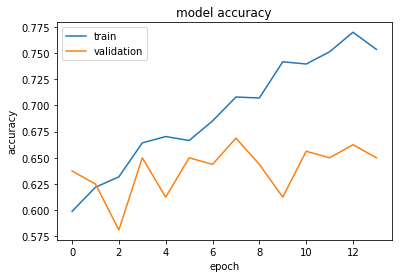

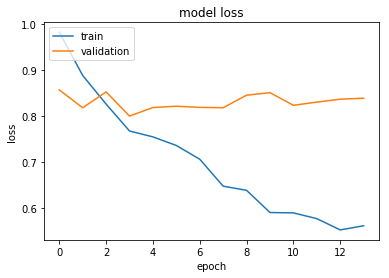

best_val_acc 0.66875
Cross-validation val accuracy results:  [0.675, 0.6875, 0.7, 0.6625, 0.66875]
Cross-validation val accuracy results: 0.68% (+/- 0.01%)
testDir dataset/test2/
Found 90 images belonging to 3 classes.
90/90 [==============================] - 4s 48ms/step
['loss', 'acc'] [0.7802213059065657, 0.6444444444444445]
90/90 [==============================] - 11s 125ms/step
predictions
 [[4.06438321e-01 3.75951409e-01 2.17610255e-01]
 [8.39015603e-01 1.40345052e-01 2.06392929e-02]
 [3.40413243e-01 3.47366393e-01 3.12220365e-01]
 [2.56693482e-01 3.56134087e-01 3.87172431e-01]
 [7.56033421e-01 1.96194842e-01 4.77717854e-02]
 [7.95658052e-01 8.32337290e-02 1.21108159e-01]
 [3.43861520e-01 2.51189888e-01 4.04948592e-01]
 [9.83463824e-01 1.50752757e-02 1.46089005e-03]
 [2.43710279e-02 1.16732053e-01 8.58896971e-01]
 [5.47655225e-01 3.68741393e-01 8.36033523e-02]
 [2.16934774e-02 1.10199861e-01 8.68106604e-01]
 [3.82714033e-01 3.51056635e-01 2.66229302e-01]
 [2.32070848e-01 6.040174

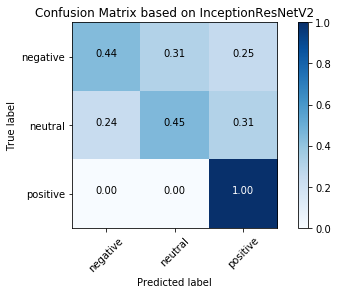

In [5]:
# Instantiate the cross validator
skf = StratifiedKFold(n_splits=kfold_splits, shuffle=True) # 
cv_accuracies = []
cv_f1s = []
    
X = input_x
y = input_y
    
# Shuffe input data
X, y = shuffle(X,y)

def setup_to_finetune(model, useF1Score):
    """Freeze the bottom LAYERS_TO_FREEZE and retrain the remaining top layers.
  note: LAYERS_TO_FREEZE corresponds to the top 2 inception blocks in the inceptionv3 arch
  Args:
    model: keras model
    """    
    totalLayers = len(model.layers)
    lastFreezeLayer = totalLayers - LAYERS_TO_UNFREEZE
    print("LAYERS_TO_UNFREEZE:", LAYERS_TO_UNFREEZE, "last layer id to freeze", lastFreezeLayer, "total layers, ",totalLayers)
    for layer in model.layers[:lastFreezeLayer]:
        layer.trainable = False
    for layer in model.layers[lastFreezeLayer:]:
        layer.trainable = True
    #optimizers.SGD(lr=0.0001, momentum=0.9)
    model.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy',\
                  metrics=imut.get_metrics(useF1Score))

def setup_to_transfer_learn(model, base_model, useF1Score):
    """Freeze all layers and compile the model"""    
    for layer in base_model.layers:
        layer.trainable = False
       
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', \
                  metrics=imut.get_metrics(useF1Score))
    print()

def add_new_last_layer(base_model, nb_classes):
    """Add last layer to the convnet
      Args:
        base_model: keras model excluding top
        nb_classes: # of classes
      Returns:
        new keras model with last layer
    """
    # 62,65,67% w/o reducing lr
    x = base_model.output
    x = Dropout(0.5)(x)
    # convert MxNxC into 1xC
    #x = GlobalAveragePooling2D()(x)
    x = GlobalMaxPooling2D()(x)
    x = Dropout(0.5)(x)
    x = Dense(FC_SIZE, activation='relu')(x) #new FC layer, random init
    x = Dropout(0.5)(x)
    output_layer = Dense(nb_classes, activation='softmax')(x) #new softmax layer
    model = Model(input=base_model.input, output=output_layer)
    #print(model.summary())
    
#     x = base_model.output
#     x = Flatten()(x)
#     x = Dropout(0.5)(x)
#     output_layer = Dense(nb_classes, activation='softmax', name='softmax')(x)
#     model = Model(inputs=base_model.input, outputs=output_layer)
    return model




def train(trainDir, valDir, config, class_weights): 
    """Use transfer learning and fine-tuning to train a network on a new dataset"""     
    
    nb_classes = len(glob.glob(trainDir + "/*"))
    
    # this is a generator that will read pictures found in
    # subfolers of 'data/train', and indefinitely generate
    # batches of augmented image data
    isForTrain = True
    train_batches = imut.get_data_generator(trainDir, config, isForTrain)  
    

    # this is a similar generator, for validation data
    isForTrain = False
    validation_batches = imut.get_data_generator(valDir, config, isForTrain)  
        
    # setup model
    base_model = ResNet152(include_top=False, weights='imagenet')
    model = add_new_last_layer(base_model, nb_classes)

    # transfer learning
    setup_to_transfer_learn(model, base_model, config['useF1Score'])
    
    # monitor='val_loss', patience = 5 default
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                                  factor=0.7, 
                                  patience=2,
                                  min_delta=0.0001,
                                  cooldown=1,
                                  min_lr=1e-7,
                                  verbose=verbose)
    # monitor='val_loss', factor=0.1, patience=10, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0
    
    filepath = model_results_root_dir + "image.weights.best.h5"
    checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=0, save_best_only=True, mode='max')
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience)    
    callbacks_list = [ early_stopping, reduce_lr]  # , checkpoint

    # train the model on the new data for a few epochs
    history = model.fit_generator(
            train_batches,
            steps_per_epoch= 2000 // config['batch_size'], # train_batches.samples
            epochs=3, 
            validation_data=validation_batches,
            validation_steps= validation_batches.samples // config['batch_size'], 
            shuffle=True,
            verbose=config['verbose']
            #callbacks=callbacks_list,
            ) # class_weight=class_weights'auto'
    
    # fine-tuning
    print("Starting fune-tuning")
    setup_to_finetune(model, config['useF1Score'])
    
    # Add checkpointing to save best model
    #callbacks_list.append(checkpoint)
    history = model.fit_generator(
            train_batches,
            steps_per_epoch=  2000 // config['batch_size'], # train_batches.samples
            epochs=config['nb_epochs'],
            validation_data=validation_batches,
            validation_steps= validation_batches.samples // config['batch_size'],
            shuffle=True,
            verbose=config['verbose'],
            callbacks=callbacks_list
            ) # 'auto' class_weight=class_weights
    return history, model




def evalaute_on_test_data(model, config):
    testDir = test_images_src
    print("testDir", testDir)
    isForTrain = False
    config['batch_size'] = 1
    
    # Divide input images into train and dev set, and each one into {negative, neutral, positive}
    isForTest = True
    dt.create_dataset("test", testDir, test_images_classified, test_x, test_y, isForTest)
    test_batches = imut.get_data_generator_for_test(test_images_classified, config) 

    results = model.evaluate_generator(test_batches, steps=test_batches.samples // config['batch_size'], verbose=1)
    print(model.metrics_names, results)
    
    predictions = model.predict_generator(test_batches, steps=test_batches.samples // config['batch_size'], verbose=1)
    print("predictions\n", predictions)
    print("\n")
    label_map_from_train_gen = (imut.get_label_map_from_train_generator(input_images_classified, config))
    print("============= label_map_from_train_gen ", label_map_from_train_gen," =================")
    intLabel_to_index = imut.convert_class_to_index_into_int(label_map_from_train_gen)
    print("intLabel_to_index", intLabel_to_index)
    predictions = imut.conver_predictions_to_classes(predictions, intLabel_to_index)
    print("predictions", predictions)
    test_filenames = test_batches.filenames
    y_true = imut.get_truth_labels_test_data(test_filenames, imageNameToLabel)
    print("y_true", y_true)
    y_pred = predictions

    cnf_matrix = confusion_matrix(y_true, y_pred)
    print("cnf_matrix", cnf_matrix)
    titleOfConfusionMatrix = "Confusion Matrix based on InceptionResNetV2"
    pt.plot_confusion_matrix_from_labels(y_true, y_pred, titleOfConfusionMatrix)
    

def prepare_and_train(config):
    bestModel = None
    final_model_val_acc = -1
    for index, (train_indices, val_indices) in enumerate(skf.split(X, y)):
        print("train_indices[:5]", train_indices[:5],"train_indices[-5:]",train_indices[-5:])
        print("val_indices[:5]", val_indices[:5],"val_indices[-5:]",val_indices[-5:])
        print()
        print("Train size: ", len(train_indices))
        print("Val size: ", len(val_indices))

        X_train, X_val = X[train_indices], X[val_indices]
        y_train, y_val = y[train_indices], y[val_indices]

        print("Train label distribution: ", pt.get_label_count(y_train))
        print("Val label distribution: ", pt.get_label_count(y_val))
        
        class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)
        print("\nclass_weights", class_weights)
        
        # Divide input images into train and dev set, and each one into {negative, neutral, positive}
        isForTest = False
        dt.create_dataset("train", input_images_src, input_images_classified, X_train, y_train, isForTest)
        dt.create_dataset("val", input_images_src, input_images_classified, X_val, y_val, isForTest)

        trainDir = input_images_classified + "/" + "train" + "/"
        valDir = input_images_classified + "/" + "val" + "/"

        history, model = train(trainDir, valDir, config, class_weights)
        
        pt.plot_model_accuracy(history, model_results_root_dir, useF1Score)
        best_val_acc = max(history.history['val_acc'])
        
        if best_val_acc > final_model_val_acc:
            bestModel = model
            final_model_val_acc = best_val_acc
        
        cv_accuracies.append(best_val_acc)
        print("best_val_acc", best_val_acc)
        if useF1Score:
            best_val_f1 = max(history.history['val_f1'])
            cv_f1s.append(best_val_f1)

    print("=========================================")
    print("Cross-validation val accuracy results: " , cv_accuracies)
    print("Cross-validation val accuracy results: %.2f%% (+/- %.2f%%)" % (np.mean(cv_accuracies), np.std(cv_accuracies)))

    if useF1Score:
        print("\n","Cross-validation val f1 results: " , cv_f1s)
        print("Cross-validation val f1 results: %.2f%% (+/- %.2f%%)" % (np.mean(cv_f1s), np.std(cv_f1s)))   
    
    # Evaluate Test data set
    evalaute_on_test_data(model, config)
    
    bestModel.save(model_results_root_dir + "/bestmodel-" + str(final_model_val_acc) + ".h5")


def get_config():
    conf = {}
    conf["img_height"] = img_height
    conf["img_width"] = img_width
    conf["kfold_splits"] = kfold_splits
    conf["batch_size"] = batch_size
    conf["nb_epochs"] = nb_epochs
    conf['useF1Score'] = useF1Score
    conf['verbose'] = verbose
    return conf    
    
def main():
    config = get_config()
    print("config:\n", config)
    prepare_and_train(config)
    # predict()
    # text_pre_processing("hello&nbsp;hi")
    pass

if __name__ == "__main__":
    # execute only if run as a script
    main()




In [6]:
print("FC_SIZE", FC_SIZE)

FC_SIZE 1024
